# **INTRODUCCIÓN**

El conjunto de datos MIT-BIH Arrhythmia de PhysioNet es uno de los más utilizados para el estudio de arritmias cardíacas en investigaciones y aplicaciones médicas. En este conjunto de datos, las anotaciones de los latidos del corazón están clasificadas en varias categorías, las cuales se suelen etiquetar con letras que corresponden a diferentes tipos de arritmias o condiciones normales.
# Clases en el conjunto de datos MIT-BIH Arrhythmia:

-'N': Normal (0)
Representa latidos normales. Estos son latidos que no tienen anomalías significativas y que generalmente se consideran típicos.
-'S': Supraventricular ectopic beats (1)
Estos son latidos ectópicos que se originan en las aurículas, que están por encima de los ventrículos del corazón. No son tan críticos como los latidos ectópicos ventriculares, pero pueden indicar problemas cardíacos si son frecuentes.

-'V': Ventricular ectopic beats (2)
Estos son latidos ectópicos que se originan en los ventrículos. Son de mayor preocupación que los latidos ectópicos supraventriculares ya que pueden indicar una mayor probabilidad de complicaciones cardíacas, incluyendo diferentes tipos de arritmias ventriculares.

-'F': Fusion of ventricular and normal beat (3)
Esto se refiere a un latido que es una fusión entre un latido ectópico ventricular y un latido normal. Puede ser difícil de detectar y de interpretar, ya que muestra características tanto de latidos normales como de latidos ectópicos.

-'Q': Unclassifiable beat (4)
Latidos que no se pueden clasificar en ninguna de las otras categorías. Puede ser debido a artefactos de señal, daño en los electrodos, o simplemente señales que no son lo suficientemente claras como para hacer una clasificación definitiva.

# Uso y Aplicaciones
Este tipo de clasificación es vital para el desarrollo de sistemas automáticos de detección de arritmias y otras aplicaciones médicas que requieren monitoreo continuo del ritmo cardíaco, como en los monitores de ECG en hospitales o dispositivos portátiles de monitoreo de salud. Los investigadores y desarrolladores de tecnología médica utilizan estas clasificaciones para entrenar algoritmos de aprendizaje automático y de procesamiento de señales que pueden identificar automáticamente estos diferentes tipos de latidos en tiempo real o en registros de larga duración.

Estas clasificaciones permiten a los médicos y a los sistemas de salud proporcionar respuestas más rápidas y precisas a las condiciones cardíacas que podrían requerir intervención.

# **IMPORTACIÓN DE LIBRERÍAS**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, ReLU, MaxPooling1D, Flatten, Dense
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from tabulate import tabulate
import seaborn as sns

# **LECTURA Y VISUALIZACIÓN DE DATOS**

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Inteligencia_artificial/mitbih_train.csv',header=None)
test_df = pd.read_csv('/content/drive/MyDrive/Inteligencia_artificial/mitbih_test.csv', header=None)

In [ ]:
print(f'Train Dataset shape : {train_df.shape}\nTest Dataset shape : {test_df.shape}')
train_df.head()

Train Dataset shape : (87554, 188)
Test Dataset shape : (21892, 188)


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


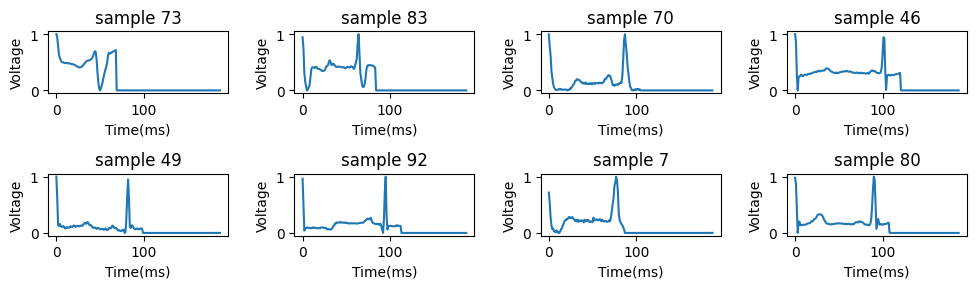

In [ ]:
index = np.random.choice(100, size=8, replace=False)

# Create a subplot grid of 4 rows and 2 columns
fig, axes = plt.subplots(2, 4, figsize=(10, 3))

# Plot each selected row in a subplot
for i, ax in enumerate(axes.flatten()):
    if i < len(index):
        row_index = index[i]
        row_values = train_df.iloc[row_index]
        ax.plot(row_values.index, row_values)
        ax.set_xlabel('Time(ms)')
        ax.set_ylabel('Voltage')
        ax.set_title(f'sample {row_index}')
    else:
        ax.axis('off')  # Turn off the empty subplots

plt.tight_layout()
plt.show()

In [ ]:
train_df[187].value_counts()

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

# **TRANSFORMACIÓN Y DIVISIÓN DE DATOS EN TRAIN Y TEST**

In [ ]:
!pip install imbalanced-learn

In [ ]:
column_name = train_df.columns[187]  # Esto obtiene el nombre de la columna en el índice 1
X = train_df.drop(column_name, axis=1)
y = train_df[187]
# Suponiendo que X e y ya están definidos
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear una instancia de SMOTE
smote = SMOTE()

# Aplicar SMOTE solo en los datos de entrenamiento para evitar información de prueba en el entrenamiento
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Ahora, X_train_smote y y_train_smote tienen las clases equilibradas


In [ ]:
np.bincount(y_train_smote)

array([50643, 50643, 50643, 50643, 50643])

# **CREACIÓN, COMPILAMIENTO Y ENTRENAMIENTO DEL MODELO DE CLASIFICACIÓN**

In [ ]:
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_smote.shape[1],)),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
y_train_smote=y_train_smote.values.reshape(-1, 1)
y_train_smote=y_train_smote.astype(int)
y_train_smote = to_categorical(y_train_smote)

In [ ]:
X_train_smote

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.933560,0.839864,0.311755,0.010221,0.114140,0.195911,0.224872,0.269165,0.262351,0.248722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.773196,0.453608,0.345361,0.335052,0.278351,0.319588,0.329897,0.340206,0.293814,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.978208,0.937046,0.784504,0.375303,0.125908,0.181598,0.171913,0.087167,0.055690,0.055690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.580292,0.000000,0.082117,0.078467,0.120438,0.158759,0.158759,0.166058,0.162409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.904366,0.929314,0.376299,0.000000,0.201663,0.349272,0.322245,0.309771,0.326403,0.313929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253210,0.959207,0.562101,0.566588,0.565698,0.544924,0.544025,0.488879,0.428644,0.276796,0.119427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
253211,0.677197,0.583986,0.472127,0.382757,0.258040,0.148615,0.065986,0.026042,0.002433,0.017165,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
253212,1.000000,0.848109,0.572506,0.338315,0.229556,0.225072,0.243982,0.245028,0.239348,0.232171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
253213,0.779754,0.504299,0.483236,0.455126,0.439518,0.410795,0.373003,0.334091,0.293265,0.203338,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
model.fit(X_train_smote, y_train_smote, epochs=50, batch_size=100, validation_split=0.2)


Epoch 1/50
2026/2026 [==============================] - 22s 10ms/step - loss: 0.3995 - accuracy: 0.8582 - val_loss: 0.4358 - val_accuracy: 0.8773
Epoch 2/50
2026/2026 [==============================] - 17s 8ms/step - loss: 0.1875 - accuracy: 0.9362 - val_loss: 0.4496 - val_accuracy: 0.8754
Epoch 3/50
2026/2026 [==============================] - 14s 7ms/step - loss: 0.1393 - accuracy: 0.9538 - val_loss: 0.2384 - val_accuracy: 0.9178
Epoch 4/50
2026/2026 [==============================] - 9s 4ms/step - loss: 0.1125 - accuracy: 0.9626 - val_loss: 0.2247 - val_accuracy: 0.9177
Epoch 5/50
2026/2026 [==============================] - 7s 4ms/step - loss: 0.0974 - accuracy: 0.9676 - val_loss: 0.2536 - val_accuracy: 0.9097
Epoch 6/50
2026/2026 [==============================] - 9s 4ms/step - loss: 0.0849 - accuracy: 0.9722 - val_loss: 0.1844 - val_accuracy: 0.9318
Epoch 7/50
2026/2026 [==============================] - 7s 3ms/step - loss: 0.0761 - accuracy: 0.9750 - val_loss: 0.2147 - val_accur

# **EVALUACIÓN DEL MODELO**

In [ ]:
y_test=y_test.values.reshape(-1, 1)
y_test=y_test.astype(int)
y_test = to_categorical(y_test)
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")


821/821 [==============================] - 2s 2ms/step - loss: 0.2001 - accuracy: 0.9697
Loss: 0.20007140934467316, Accuracy: 0.9696958065032959


# **VISUALIZACIÓN DE RESULTADOS**

821/821 [==============================] - 1s 2ms/step


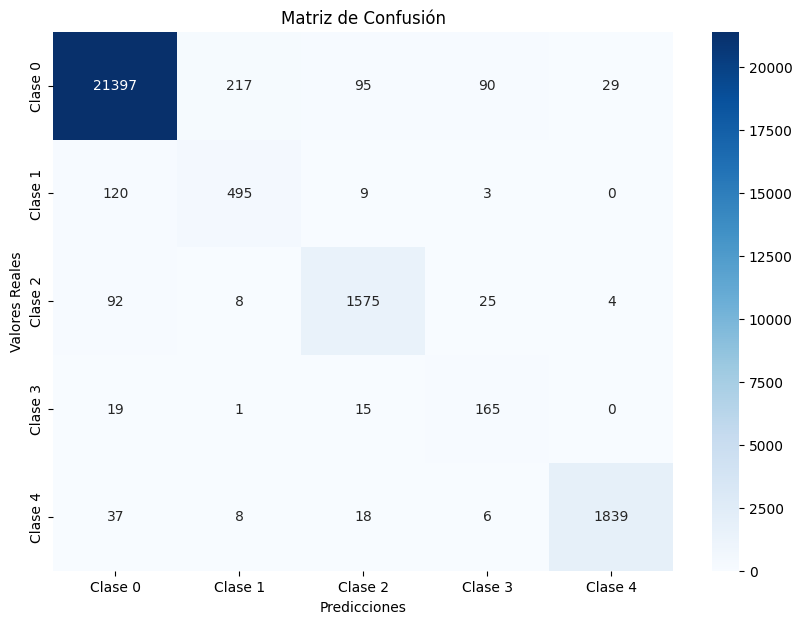

In [ ]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)
y_test = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_test, predictions)

# Etiquetas de las clases para la matriz de confusión
class_labels = ['Clase 0', 'Clase 1', 'Clase 2', 'Clase 3', 'Clase 4']  # Ajusta esto a tus etiquetas de clase

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()